In [1]:
import pandas as pd

In [2]:
df_tx = pd.read_parquet("transaction_fraud_data.parquet")
df_fx = pd.read_parquet("historical_currency_exchange.parquet")

In [21]:
print(df_tx.info(memory_usage="deep"))
print(df_fx.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 31 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [22]:
print("\nDate range:", df_tx["timestamp"].min(), df_tx["timestamp"].max())
print("Rows:", len(df_tx), " | Unique customers:", df_tx["customer_id"].nunique())


Date range: 2024-09-30 00:00:01.034820 2024-10-30 23:59:59.101885
Rows: 7483766  | Unique customers: 4869


In [5]:
fraud_counts = df_tx["is_fraud"].value_counts(dropna=False)
fraud_rate = df_tx["is_fraud"].mean()
print("\nFraud counts:\n", fraud_counts)
print("Overall fraud rate: {:.2%}".format(fraud_rate))


Fraud counts:
 is_fraud
False    5989047
True     1494719
Name: count, dtype: int64
Overall fraud rate: 19.97%


In [6]:
top_cat = (
    df_tx.groupby("vendor_category")["is_fraud"]
         .agg(["count", "sum", "mean"])
         .rename(columns={"count": "transactions", "sum": "frauds", "mean": "fraud_rate"})
         .sort_values("frauds", ascending=False)
         .head(10)
)
print(top_cat)

                 transactions  frauds  fraud_rate
vendor_category                                  
Travel                 935790  187477    0.200341
Grocery                934029  186987    0.200194
Restaurant             936178  186951    0.199696
Entertainment          936173  186890    0.199632
Gas                    935401  186829    0.199731
Healthcare             936770  186769    0.199376
Retail                 935883  186613    0.199398
Education              933542  186203    0.199459


In [7]:
top_country = (
    df_tx.groupby("country")["is_fraud"]
         .agg(["count", "sum", "mean"])
         .rename(columns={"count": "transactions", "sum": "frauds", "mean": "fraud_rate"})
         .query("transactions >= 100")         
         .sort_values("fraud_rate", ascending=False)
         .head(10)
)
print(top_country)

           transactions  frauds  fraud_rate
country                                    
Mexico           785704  298841    0.380348
Russia           793730  299425    0.377238
Brazil           804800  298629    0.371060
Nigeria          849840  298600    0.351360
Australia        496695   37652    0.075805
USA              500060   37312    0.074615
Japan            527393   37592    0.071279
Germany          524464   37205    0.070939
Canada           532632   37278    0.069988
UK               538493   37345    0.069351


In [8]:

latest_fx = df_fx.sort_values("date").iloc[-1].to_dict()  
latest_fx["USD"] = 1.0  

def to_usd(row):
    rate = latest_fx.get(row["currency"], None)
    return row["amount"] / rate if rate else None

df_tx["amount_usd"] = df_tx.apply(to_usd, axis=1)


In [ ]:
flags = [
    "is_high_risk_vendor",
    "is_outside_home_country",
    "is_weekend",
    "is_card_present",  
]

flag_summary = (
    df_tx[flags + ["is_fraud"]]
      .melt(id_vars="is_fraud", var_name="flag", value_name="value")
      .groupby(["flag", "value"])["is_fraud"]
      .agg(["count", "sum", "mean"])
      .rename(columns={"count": "transactions", "sum": "frauds", "mean": "fraud_rate"})
      .reset_index()
)
print(flag_summary)

combo_summary = (
    df_tx
      .groupby(flags)["is_fraud"]
      .agg(["count", "sum", "mean"])
      .rename(columns={"count": "transactions", "sum": "frauds", "mean": "fraud_rate"})
      .reset_index()
      .sort_values("fraud_rate", ascending=False)
)
print(combo_summary.head(10))


                      flag  value  transactions   frauds  fraud_rate
0          is_card_present  False       6832719   843672    0.123475
1          is_card_present   True        651047   651047    1.000000
2      is_high_risk_vendor  False       5611803  1120352    0.199642
3      is_high_risk_vendor   True       1871963   374367    0.199986
4  is_outside_home_country  False       5073605   126343    0.024902
5  is_outside_home_country   True       2410161  1368376    0.567753
6               is_weekend  False       5554103  1109277    0.199722
7               is_weekend   True       1929663   385442    0.199746
    is_high_risk_vendor  is_outside_home_country  is_weekend  is_card_present  \
1                 False                    False       False             True   
3                 False                    False        True             True   
5                 False                     True       False             True   
7                 False                     True       

In [ ]:

df_tx["amount_decile"] = pd.qcut(df_tx["amount_usd"], 10, labels=False, duplicates="drop")

decile_summary = (
    df_tx.groupby("amount_decile")["is_fraud"]
         .agg(["count", "sum", "mean"])
         .rename(columns={"count": "transactions", "sum": "frauds", "mean": "fraud_rate"})
)
print(decile_summary)


               transactions  frauds  fraud_rate
amount_decile                                  
0                    748377  486537    0.650123
1                    748377   57880    0.077341
2                    748376   60488    0.080826
3                    748380   47436    0.063385
4                    748379   43159    0.057670
5                    748387   43262    0.057807
6                    748366   54289    0.072543
7                    748373  127009    0.169713
8                    748374  195149    0.260764
9                    748377  379510    0.507111


In [12]:
df_tx["hour"] = df_tx["timestamp"].dt.hour
hourly = (
    df_tx.groupby("hour")["is_fraud"]
         .agg(["count", "sum", "mean"])
         .rename(columns={"count": "transactions", "sum": "frauds", "mean": "fraud_rate"})
)
print(hourly.head(24))


      transactions  frauds  fraud_rate
hour                                  
0           155759   41519    0.266559
1           280136  165999    0.592566
2           280472  166025    0.591949
3           280031  165621    0.591438
4           281466  166418    0.591254
5           208529   41829    0.200591
6           196875   41622    0.211413
7           301176   41318    0.137189
8           405312   41523    0.102447
9           352451   41522    0.117809
10          300516   41410    0.137796
11          352499   41857    0.118744
12          404942   41716    0.103017
13          352556   41829    0.118645
14          300152   41665    0.138813
15          300554   41705    0.138760
16          352379   41407    0.117507
17          404657   41423    0.102366
18          456393   41400    0.090711
19          404823   41786    0.103220
20          300832   41188    0.136914
21          196566   41049    0.208831
22          332961   41431    0.124432
23          281729   4145

In [ ]:
activity_cols = ["num_transactions", "total_amount", "unique_merchants", "unique_countries", "max_single_amount"]
act_df = pd.json_normalize(df_tx["last_hour_activity"])
act_df.columns = [f"lha_{c}" for c in activity_cols]
df_tx = df_tx.join(act_df)

corr = df_tx[["is_fraud"] + act_df.columns.tolist()].corr(numeric_only=True)["is_fraud"].sort_values(ascending=False)
print(corr)


is_fraud                 1.000000
lha_max_single_amount    0.009226
lha_unique_countries     0.009046
lha_unique_merchants     0.006932
lha_num_transactions     0.004506
lha_total_amount         0.003332
Name: is_fraud, dtype: float64


In [ ]:

cp_table = (
    df_tx
      .groupby(["channel", "is_card_present"])["is_fraud"]
      .agg(["count", "mean"])
      .rename(columns={"count": "transactions", "mean": "fraud_rate"})
)
print(cp_table.sort_index())


                         transactions  fraud_rate
channel is_card_present                          
mobile  False                 2269578    0.123878
pos     True                   651047    1.000000
web     False                 4563141    0.123275


In [17]:
rule_pred = (df_tx["is_outside_home_country"] & df_tx["is_card_present"]).astype(int)
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_true = df_tx["is_fraud"].astype(int)
print("Precision:", precision_score(y_true, rule_pred))
print("Recall   :", recall_score(y_true, rule_pred))
print("Confusion:\n", confusion_matrix(y_true, rule_pred))


Precision: 1.0
Recall   : 0.39861070876867155
Confusion:
 [[5989047       0]
 [ 898908  595811]]


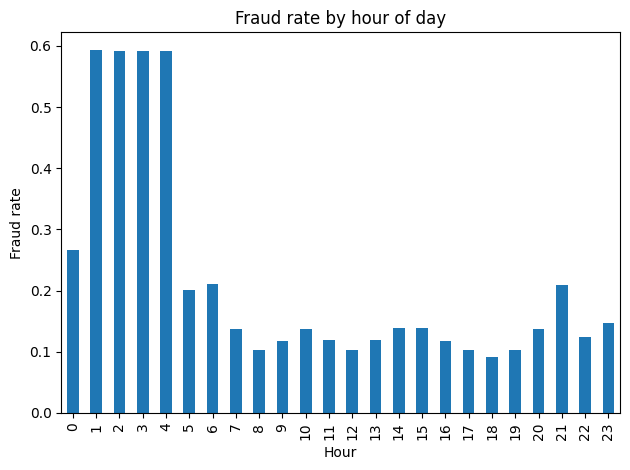

In [16]:
import matplotlib.pyplot as plt

hourly["fraud_rate"].plot(kind="bar")
plt.title("Fraud rate by hour of day")
plt.xlabel("Hour")
plt.ylabel("Fraud rate")
plt.tight_layout()
plt.show()


In [ ]:
base_feats = [
    "amount_usd",
    "hour",
    "is_card_present",
    "is_outside_home_country",
    "is_high_risk_vendor",
    "vendor_category",
    "channel",
    "country",
    "card_type",
]
from sklearn.model_selection import train_test_split
X = pd.get_dummies(df_tx[base_feats], drop_first=True)
y = df_tx["is_fraud"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [25]:
df_tx["hour_risk"] = df_tx["hour"].isin([1,2,3,4])
df_tx["amount_extreme"] = df_tx["amount_decile"].isin([0,9])

rule2_pred = (
    df_tx["is_outside_home_country"] & df_tx["is_card_present"] |
    (df_tx["hour_risk"] & df_tx["is_card_present"]) |
    (df_tx["is_outside_home_country"] & df_tx["amount_extreme"])
).astype(int)

from sklearn.metrics import precision_score, recall_score
print("Rule-2 precision:", precision_score(y_true, rule2_pred))
print("Rule-2 recall   :", recall_score(y_true, rule2_pred))


Rule-2 precision: 0.9072338525074548
Rule-2 recall   : 0.7148574414321354


In [27]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

num_cols = ["amount_usd", "hour"] + [c for c in df_tx.columns if c.startswith("lha_")]
bin_cols = ["is_card_present", "is_outside_home_country", "is_high_risk_vendor",
            "hour_risk", "amount_extreme"]

cat_cols = ["vendor_category", "channel", "country", "card_type"]

X = pd.concat([
        df_tx[num_cols],
        df_tx[bin_cols].astype(int),
        pd.get_dummies(df_tx[cat_cols], drop_first=True)
    ], axis=1)

y = df_tx["is_fraud"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary"
)
clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="auc")

print("Validation AUC:", roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))
feat_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]
print(feat_imp)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1195775, number of negative: 4791237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1221
[LightGBM] [Info] Number of data points in the train set: 5987012, number of used features: 36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199728 -> initscore=-1.387994
[LightGBM] [Info] Start training from score -1.387994
Validation AUC: 0.9957634705293336
amount_usd                    2598
card_type_Platinum Credit      611
country_Nigeria                565
vendor_category_Travel         467
hour                           350
vendor_category_Retail         327
country_Russia                 